# Coding project - Tumor segmentation
The image below is a slice of a brain MRI with a large tumor in it. The goal of this project is to create an algorithm to automatically segment the tumor.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumor (in cm²).

First, we will read and display the image.

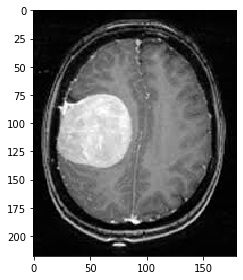

In [1]:
from skimage.io import imread,imshow
%matplotlib inline

brainImage = imread('mri_brain.jpg')
imshow(brainImage)

# How to Segment

When we look at the picture, we can see that the difference between the tumor and the rest of the brain is the color. The pixels of the tumor are close to the white pixels.

The first thing we can do is keep graylevels above a certain threshold (160 for example).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


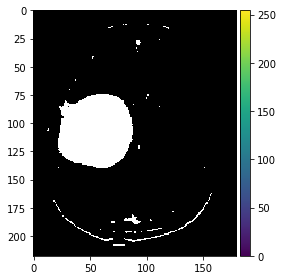

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.io import imshow
from PIL import Image
%matplotlib inline

#read the original MRI
brainImage = Image.open('mri_brain.jpg')

lut_thresh = np.zeros((256,))
t = 160
for i in range(t): lut_thresh[i] = 0
for i in range(t,256): lut_thresh[i] = i 
brainImage = lut_thresh[brainImage]

imshow(brainImage)

We can see that the tumor is now a big white element. Now, we need to segment it as an object in order to recognize measure informations.
We will use a label and regionprops to define the white pixels as "props".

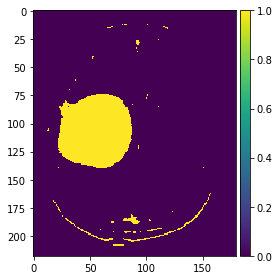

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from skimage.io import imread,imshow
from skimage.measure import label,regionprops
from skimage.morphology import disk
from skimage.color import rgb2gray
from PIL import Image
%matplotlib inline

#read the original MRI
brainImage = Image.open('mri_brain.jpg')

lut_thresh = np.zeros((256,))
t = 160
for i in range(t): lut_thresh[i] = 0
for i in range(t,256): lut_thresh[i] = i 
brainImage = lut_thresh[brainImage]

brainImage = (brainImage[:,:,0]>0).astype(int)
imshow(brainImage)

#extract connected components
label = label(brainImage, connectivity=1)

#Measure properties of labeled image regions
props = regionprops(label)




# Get tumour's area

Now that all the objects are detected, we need to know which one is the tumor. We will look into all the props to find the one with the biggest area. We can see by displaying all the results that the tumor area is very bigger than the other. There is no mistake possible with a big tumor like this.

In [4]:
#Get the bigest region
tumorArea = 0
for prop in props:
    if(prop.area > tumorArea):
        tumorArea = prop.area

print("The tumor is made of " + str(tumorArea) + " pixels")

The tumor is made of 3521 pixels


Finally, we will convert the pixels area into centimeters. Since the resolution is 0,115cm/px on both axis, on pixel is 0,013225 cm². We need to multiply the number of pixels by this value to get the tumor Area

In [5]:

#Convert the pixel area in cm 
tumorArea = 0.013225 * tumorArea
print("The area of the tumor is " + str(tumorArea) + " cm²")

The area of the tumor is 46.565225000000005 cm²


# Additional features

One thing that can be very useful in medicine is to apply a filter on the MRI to see the different region of the tumor. Since a tumor has also a different texture, we can also use the texture segmentation. We need a window of (1,1) pixels to have a better precision. Then, we can extract the tumor as a mask, with a treshold. When we look at the colored picture, we can see that the threshold should be around 180 to get only the tumor.

Text(0.5, 1.0, 'Descriptor image')

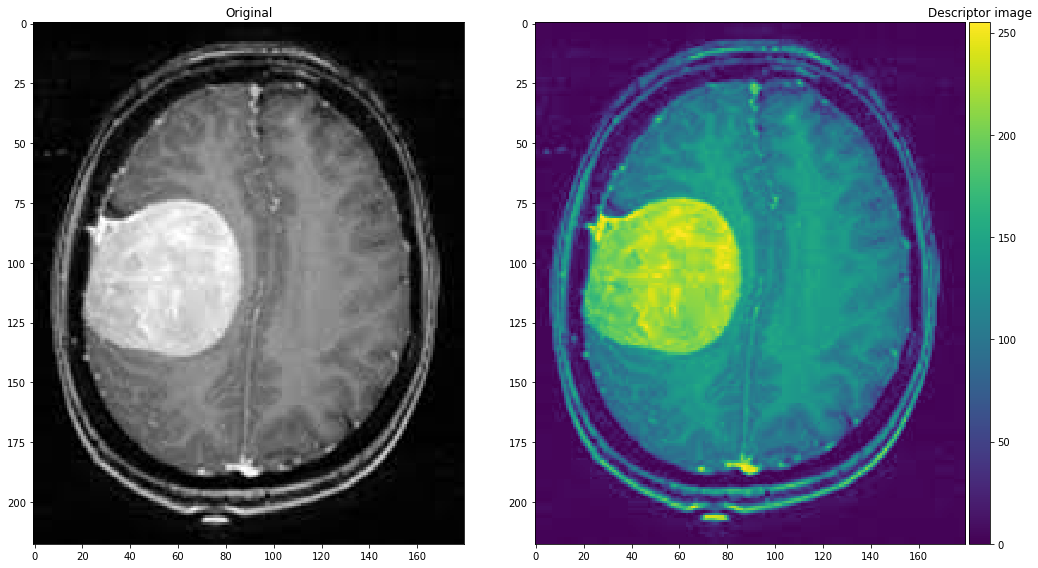

In [6]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

def texture_descriptor(N):
    e = N.max()
    return e

def sliding_window(im, PATCH_SIZE, STRIDE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, STRIDE):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, STRIDE):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            c = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2) # center of the patch
            output[c[0]-STRIDE:c[0]+STRIDE, c[1]-STRIDE:c[1]+STRIDE] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("mri_brain.jpg", as_gray=True))

im_descr = sliding_window(im.astype('float'),(1,1), 1)

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
imshow(im)
plt.title('Original')
plt.subplot(1,2,2)
imshow(im_descr)
plt.title('Descriptor image')

The next step is to do a thresholding on the output image. The problem is that we have to ignore pixels under 60 to get the tumour. If not, we will get the entire brain.

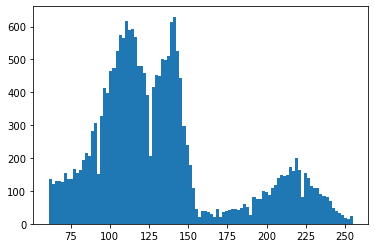

In [7]:
plt.figure()
plt.hist(im_descr[im_descr>60].flatten(), bins=100)
plt.show()

Then, we can use the Otsu function to find the best threshold :

Best threshold: 163.82


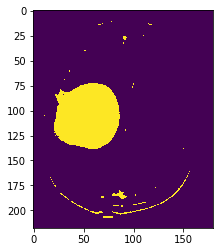

In [8]:
def otsu_threshold(h):
    p = h*1./h.sum() # Probability histogram
    
    # Check every possible threshold
    best_l = 0
    best_t = 0
    
    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    for t in range(1,len(h)-1):
        # Class probabilities
        w0 = p[:t].sum()
        w1 = p[t:].sum()
        # Class means
        m0 = (np.arange(0,t)*p[:t]).sum()/w0
        m1 = (np.arange(t,len(h))*p[t:]).sum()/w1
        # Class variances
        s0 = (((np.arange(0,t)-m0)**2)*p[:t]).sum()/w0
        s1 = (((np.arange(t,len(h))-m1)**2)*p[t:]).sum()/w1
        # Intra-class
        sw = w0*s0+w1*s1
        # Inter-class
        sb = w0*w1*((m1-m0)**2)
        # Separability
        l = sb/sw
        if( l > best_l ):
            best_l = l
            best_t = t
        var_within[t] = sw
        var_between[t] = sb
        sep[t] = l
    
    return best_t, var_within, var_between, sep

h,bins = np.histogram(im_descr[im_descr>60],bins=100)
t,vw,vb,s = otsu_threshold(h)
print("Best threshold: %.2f"%bins[t])

plt.figure()
plt.imshow(im_descr>bins[t])
plt.show()

Finally, we will use this threshold to define a mask that we will apply to the original MRI. It segment the tumor as in our first method. We should obtain more or less the same result if we calculate the tumour's area with this mask image.

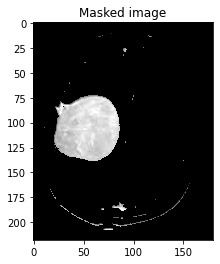

In [9]:
mask = im_descr>bins[t]
plt.figure()
plt.title('Masked image')
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()